In [3]:
import os, sys, warnings, pickle
from typing import Optional
from scipy.stats import norm
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

from scripts.config import *
from scripts.data_processing.common_methods import get_processed_data, get_group_id
from scripts.modeling.common_methods import truncate_colormap

/opt/anaconda3/envs/envTL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plot Aging Trajectories of Each Dataset

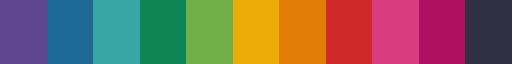

In [8]:
#region: Colors used in Rapid SOH paper
# colors = [
# 	'#4E79A7', '#A0CBE8', 
# 	'#F28E2B', '#FFBE7D',
# 	'#59A14F', '#8CD17D',
# 	'#D37295', '#FABFD2',
# 	'#499894', '#86BCB6',
# 	'#E15759', '#FF9D9A',
# 	'#363433', '#94908e',
# 	'#B6992D', '#F1CE63',
# 	'#B07AA1', '#D4A6C8',
# 	'#9D7660', '#D7B5A6',
# 	'#637939', '#8CA252',
# ]
# color_bins = np.arange(0,22,1)
# assert len(color_bins)== len(colors)
# cmap = mpl.colors.ListedColormap(colors)
#endregion

# define colormap
colors_cyc_groups = [
	'#5F4690FF', 
	'#1D6996FF', 
	'#38A6A5FF', 
	'#0F8554FF', 
	'#73AF48FF', 
	'#EDAD08FF', 
	'#E17C05FF', 
    '#CF292BFF', 
	'#D93D7FFF',
    '#AF1060FF',
	'#303043FF']
cmap_cyc_groups = mpl.colors.ListedColormap(colors_cyc_groups)
cmap_cyc_groups


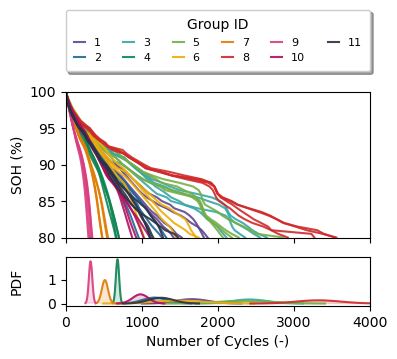

In [12]:
def plot_aging_trajectories(dataset_id:str, plot_all_trajectories:bool=False, isolate_group:Optional[int]=None, extrapolate:bool=False, soh_bounds:tuple=(80,100), save:bool=False, **kwargs) -> tuple:
	"""Plots the aging trajectories of the LFP/Gr dataset.

	Args:
		dataset_id (str): {"UConn-ILCC-LFP", "UConn-ILCC-NMC"}
		plot_all_trajectories (bool, optional): If True, the trajectory of each cell is plotted. Else, the mean trajectory of each cycling group is plotted. Defaults to False.
		isolate_group (int, Optional): The specified group ID will be shown with all other groups grayed out. Default is None.
		extrapolate (bool, optional): Whether to linearly extend the aging trajectories to future SOHs. Data will be extended to the lower limit of the 'soh_bounds' parameter. Defaults to False.
		soh_bounds (tuple, optional): The SOH bounds to plot between. Defaults to (80,100).
		save (bool, optional): Whether to save the figure. If True, the path location of the saved plot is printed. Defaults to False
		**kwargs: [fig, axes]
	Returns:
		tuple: (fig, axes)
	"""

	assert isolate_group is None or isolate_group in np.arange(1, dic_available_dataset_info[dataset_id]['group_count']+1)

	from scipy.stats import norm
	with warnings.catch_warnings():
		warnings.simplefilter('ignore')
		all_data = get_processed_data(dataset_id=dataset_id, data_type='slowpulse')
	data = {'Cell ID':[], 'Group ID':[], 'RPT':[], 'Num Cycles':[], 'Capacity (Ah)':[], 'SOH (%)':[]}

	#region: calculate required features
	for cell_id in np.unique(all_data['cell_id']):
		filt_idxs = np.where((all_data['cell_id'] == cell_id) & (all_data['pulse_type'] == 'chg') & (all_data['soc'] == 20))
		sort_idxs = np.argsort(all_data['rpt'][filt_idxs])

		rpts = all_data['rpt'][filt_idxs][sort_idxs]
		cycles = all_data['num_cycles'][filt_idxs][sort_idxs]
		# cycles may be NaN (missing cycling data for that week)
		# replace with average of cycles from previous and next weeks
		for idx in np.where(np.isnan(cycles))[0]:
			lb = cycles[idx-1] if idx > 1 and not np.isnan(cycles[idx-1]) else None
			ub = cycles[idx+1] if idx < len(cycles)-1 and not np.isnan(cycles[idx+1]) else None

			if lb is None and ub is None: 
				cycles[idx] = 0
				raise RuntimeWarning("Consecutive RPTs are missing cycle numbers")
			elif lb is None: cycles[idx] = ub
			elif ub is None: cycles[idx] = lb
			else: cycles[idx] = (lb + ub) / 2
		q_dchgs = all_data['q_dchg'][filt_idxs][sort_idxs]
		sohs = q_dchgs / q_dchgs[0] * 100

		assert len(np.where(np.isnan(cycles))[0]) == 0
		assert len(rpts) == len(cycles) == len(q_dchgs) == len(sohs)

		data['Cell ID'].append(np.full_like(rpts, cell_id))
		data['Group ID'].append(np.full_like(rpts, get_group_id(dataset_id, cell_id)))
		data['RPT'].append(rpts)
		data['Num Cycles'].append(np.cumsum(cycles))
		data['Capacity (Ah)'].append(q_dchgs)
		data['SOH (%)'].append(sohs)

	data['Cell ID'] = np.hstack(data['Cell ID'])
	data['Group ID'] = np.hstack(data['Group ID'])
	data['RPT'] = np.hstack(data['RPT'])
	data['Num Cycles'] = np.hstack(data['Num Cycles'])
	data['Capacity (Ah)'] = np.hstack(data['Capacity (Ah)'])
	data['SOH (%)'] = np.hstack(data['SOH (%)'])
	#endregion

	#region: interpolate data to fixed SOH increments
	cols_for_interp = ['Cell ID', 'Group ID', 'Num Cycles', 'Capacity (Ah)', 'SOH (%)']
	data_interp = {k:[] for k in cols_for_interp}
	sohs_interp = np.arange(soh_bounds[1], soh_bounds[0]-0.5, -0.5)
	for cell_id in np.unique(data['Cell ID']):
		filt_idxs = np.where(data['Cell ID'] == cell_id)
		data_interp['SOH (%)'].append(sohs_interp)
		data_interp['Cell ID'].append( np.full(len(sohs_interp), cell_id) )
		data_interp['Group ID'].append( np.full(len(sohs_interp), data['Group ID'][filt_idxs][0]) )

		for column in ['Num Cycles', 'Capacity (Ah)']:
			#region: interpolate feature to pre-defined SOH increments
			sohs = data['SOH (%)'][filt_idxs]
			vals = data[column][filt_idxs]

			interp_success = False
			f = None
			while not interp_success:
				try:
					f = interpolate.PchipInterpolator(np.flip(sohs), np.flip(vals), extrapolate=False)
					interp_success = True
				except ValueError:
					for i in range(1, len(sohs)):
						if sohs[i-1] <= sohs[i]: 
							sohs[i-1] = sohs[i]+0.000001
			vals_interp = f(sohs_interp)
			#endregion
			
			#region: linearly extrapolate cells for lower SOHs
			if extrapolate:
				n_samples_to_fit = 2
				last_three_idxs = np.zeros(n_samples_to_fit)       # last n idxs on non-nan values
				for i in range(len(vals_interp)):
					if not np.isnan(vals_interp[i]):
						last_three_idxs[i%n_samples_to_fit] = i
				last_three_idxs = np.sort(last_three_idxs).astype(int)

				p = np.poly1d(np.polyfit(sohs_interp[last_three_idxs], vals_interp[last_three_idxs], deg=1))
				vals_interp[np.max(last_three_idxs)+1:] = p(sohs_interp[np.max(last_three_idxs)+1:])
			#endregion
			
			data_interp[column].append(vals_interp)

	#region: format interpolated dataframe for plotting
	data_interp = {k:np.asarray(v).ravel() for k,v in data_interp.items()}
	df_plotting_interp = pd.DataFrame(data_interp)
	df_plotting_interp['Group ID'] = df_plotting_interp['Group ID'].astype(int)
	#endregion
	#endregion

	#region: define colors for each group
	cmap = cmap_cyc_groups
	cnorm = mpl.colors.Normalize(vmin=0, vmax=12)
	sc_map = mpl.cm.ScalarMappable(cmap=cmap, norm=cnorm)
	sc_map.set_array([])
	#endregion

	#region: Plot aging trajectory of each group w/ group distribution below X axis
	fig, axes = None, None
	if 'fig' in kwargs and 'axes' in kwargs: 
		fig = kwargs['fig']
		axes = kwargs['axes']
	else:
		fig = plt.figure(figsize=(4,4))
		gs = GridSpec(figure=fig, nrows=2, ncols=1, height_ratios=[3,1])
		axes = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
		axes[1].sharex(axes[0])

	max_num_cycles = int((np.ceil(np.max(data['Num Cycles'][np.where(data['SOH (%)'] >= soh_bounds[0])]) / 500)+1) * 500)

	all_group_ids = df_plotting_interp['Group ID'].dropna(inplace=False).unique()
	if not isolate_group is None:
		# resort group_ids so isolate_group gets plotted last
		orig_idxs = np.arange(len(all_group_ids))
		iso_group_idx = np.argwhere(all_group_ids == isolate_group)[0][0]
		new_indices = np.concatenate((orig_idxs[orig_idxs != iso_group_idx], [iso_group_idx]))
		all_group_ids = all_group_ids[new_indices]

	for group_id in all_group_ids:
		group_id = int(group_id)
		df_group = df_plotting_interp.loc[df_plotting_interp['Group ID'] == group_id]
		color_idx = int(group_id)-1
		
		# get avg and std of trajectory for each group
		df_avg = df_group.groupby('SOH (%)', dropna=True).mean().reset_index()
		df_std = df_group.groupby('SOH (%)', dropna=True).std().reset_index()
		
		# set this groups color (or isolate if specified)
		alpha = 0.9
		line_color = cmap(color_idx)
		if isolate_group is not None and not isolate_group == group_id: 
			line_color = '#525252'		# gray
			alpha = 0.2

		# plot all cell trajectories
		if plot_all_trajectories:
			add_label = True
			for cell_id in df_group['Cell ID'].unique():
				df_cell = df_group.loc[df_group['Cell ID'] == cell_id]
				if add_label:
					axes[0].plot(df_cell['Num Cycles'].values, df_cell['SOH (%)'].values,
								'-', c=line_color, alpha=alpha, label=group_id)
					add_label = False
				else:
					axes[0].plot(df_cell['Num Cycles'].values, df_cell['SOH (%)'].values,
								'-', c=line_color, alpha=alpha)
		
		# plot only mean trajectory
		else:
			axes[0].plot(df_avg['Num Cycles'].values, df_avg['SOH (%)'].values,
						'-', linewidth=3, c=line_color, alpha=alpha, label=group_id)
		
		#region: plot distributions
		def find_closest_idx(value, df, colname='SOH (%)'):
			exactmatch = df.loc[df[colname] == value]
			if not exactmatch.empty:
				return exactmatch.index.values[0]
			elif df[colname].min() > soh_bounds[0]:
				return df[colname].idxmin()
			else:
				lower_idx = df.loc[df[colname] < value][colname].idxmin()
				upper_idx = df.loc[df[colname] > value][colname].idxmax()
				lower_val = df[colname][lower_idx]
				upper_val = df[colname][upper_idx]
				if (value - lower_val) / (upper_val - lower_val) > 0.5:
					return upper_idx
				else:
					return lower_idx
		
		if not axes[1] is None:
			# if you set a lower SOH bound that is lower than the EOL for a given cell,
			# 	we need to find the index of where that cell reached its EOL
			# if cell's true EOL is lower than the specified SOH bound, we return the cycle distributions 
			# 	at that SOH level
			distr_idx = find_closest_idx(soh_bounds[0], df_avg, colname='SOH (%)')
			mean_cycles = df_avg['Num Cycles'][distr_idx]
			if np.isnan(mean_cycles):
				warning_msg = f"WARNING: No cells in cycling group {group_id} are aged to the lower " + \
							f"SOH bound of {soh_bounds[0]}% SOH. The end-of-life PDF for this group cannot " + \
							f"be shown. Either increase the lower SOH bound or set 'extrapolate' to True."
				print(warning_msg)
			xvals = np.linspace(mean_cycles - 3*df_std['Num Cycles'][distr_idx],
								mean_cycles + 3*df_std['Num Cycles'][distr_idx],
								100)
			axes[1].plot(xvals, 
						norm.pdf(xvals, 
								loc=df_avg['Num Cycles'][distr_idx], 
								scale=df_std['Num Cycles'][distr_idx])*100,
						c=line_color, alpha=alpha)
			axes[1].fill(xvals, 
						norm.pdf(xvals, 
								loc=df_avg['Num Cycles'][distr_idx], 
								scale=df_std['Num Cycles'][distr_idx])*100,
						alpha=0.2*alpha,
						c=line_color)
		#endregion
	#endregion

	#region: set title and labels
	if not 'fig' in kwargs:
		axes[0].legend(title='Group ID', ncol=6, fontsize=8,
						loc='upper center', bbox_to_anchor=(0.5, 1.6), handlelength=1, borderpad=0.75,
						fancybox=True, shadow=True)
		axes[0].set_ylim(soh_bounds)
		axes[0].set_xlim(0, max_num_cycles)
		axes[0].set_ylabel("SOH (%)")
		if not axes[1] is None:
			axes[1].set_xlabel("Number of Cycles (-)")
			axes[1].set_ylabel("PDF")
		plt.setp(axes[0].get_xticklabels(), visible=False)

		fig.align_labels()
		fig.tight_layout(pad=0.8)
	#endregion

	if save: 
		dir_save = dir_figures.joinpath("Aging Trajectories", dataset_id)
		dir_save.mkdir(parents=True, exist_ok=True)
		filename = f"Aging Trajectory - {'GroupMean' if not plot_all_trajectories else 'AllCells'}{'-Extrap' if extrapolate else ''}-{soh_bounds}.png"
		plt.savefig(dir_save.joinpath(filename), dpi=300)
		print(f"Figure saved to: {dir_save.joinpath(filename)}")

	return fig, axes

fig, axes = plot_aging_trajectories(
	dataset_id='UConn-ILCC-NMC',
	plot_all_trajectories=True,	# True plots all individual cell trajectories, False plots the group mean trajectory
	isolate_group=None,
	extrapolate=False,
	soh_bounds=(80,100),
	save=False)
# Uncomment the next line to remove the legend
# axes[0].get_legend().remove()
plt.show()

# save figures (set if to True if want to save all plots)
if False:
	for dataset_id in ['UConn-ILCC-LFP', 'UConn-ILCC-NMC']:
		dir_save = dir_figures.joinpath("Aging Trajectories", dataset_id)
		for f_type in ['.png', '.pdf']:
			# Plot all cell trajectories
			filename = f"Aging Trajectory - AllCells{f_type}"
			fig, axes = plot_aging_trajectories(
				dataset_id=dataset_id,
				plot_all_trajectories=True,
				isolate_group=None,
				extrapolate=False,
				soh_bounds=(80,100),
				save=False)
			fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
			plt.close()

			# Plot group mean trajectory
			filename = f"Aging Trajectory - GroupMean{f_type}"
			fig, axes = plot_aging_trajectories(
				dataset_id=dataset_id,
				plot_all_trajectories=False,
				isolate_group=None,
				extrapolate=False,
				soh_bounds=(80,100),
				save=False)
			fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
			plt.close()

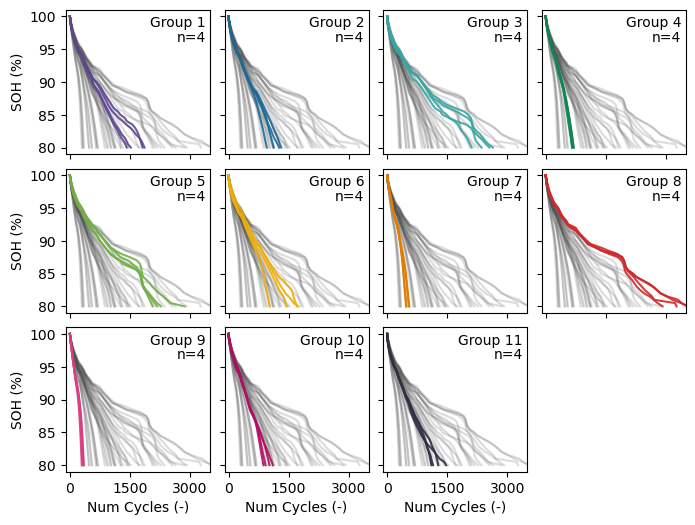

In [14]:

def plot_aging_trajectories_isolated(dataset_id:str, plot_all_trajectories:bool=True):
	"""
	Args:
		dataset_id (str): {"UConn-ILCC-LFP", "UConn-ILCC-NMC"}
        plot_all_trajectories (bool, optional): If True, the trajectory of each cell is plotted. Else, the mean trajectory of each cycling group is plotted. Defaults to False.
	"""

	fig = plt.figure(figsize=(8,6))
	gs = GridSpec(figure=fig, ncols=4, nrows=3, wspace=0.1, hspace=0.1)
	axes = [
		fig.add_subplot(gs[i//4, i%4]) for i in range(11)
	]
	for i in range(1, len(axes)):
		axes[i].sharex(axes[0])
		axes[i].sharey(axes[0])
	for g_id in np.arange(1, 11.5, 1, dtype=int):
		_fig, _axes = plot_aging_trajectories(
			dataset_id=dataset_id,
			plot_all_trajectories=plot_all_trajectories,
			isolate_group=g_id,
			extrapolate=False,
			soh_bounds=(80,100),
			save=False,
			
			fig = fig,
			axes = (axes[g_id-1], None))
	for i in range(len(axes)):
		r = i // 4
		c = i % 4
		#region: add group id and cell count annotations
		axes[i].annotate(f"Group {int(i+1)}", xy=(0.97,0.88), xycoords='axes fraction', ha='right')
		num_cells = 4
		if dataset_id == 'UConn-ILCC-LFP' and not i == 10: 
			num_cells = 6
		axes[i].annotate(f"n={int(num_cells)}", xy=(0.97,0.78), xycoords='axes fraction', ha='right')
		#endregion

		#region: add x and y labels
		if c == 0:
			axes[i].set_ylabel("SOH (%)")
			axes[i].set_yticks(np.arange(80,101,5))
		else:
			plt.setp(axes[i].get_yticklabels(), visible=False)
		if r == 2:
			axes[i].set_xlabel("Num Cycles (-)")
			if dataset_id == 'UConn-ILCC-LFP':
				axes[i].set_xticks(np.arange(0,9001,3500))
				axes[i].set_xlim([-300,9000])
			elif dataset_id == 'UConn-ILCC-NMC':
				axes[i].set_xticks(np.arange(0,3401,1500))
				axes[i].set_xlim([-100,3500])
		else:
			plt.setp(axes[i].get_xticklabels(), visible=False)
		#endregion
			
	return fig, axes

dataset_id = 'UConn-ILCC-NMC'
fig, axes = plot_aging_trajectories_isolated(
	dataset_id=dataset_id,
	plot_all_trajectories=True,
)
plt.show()

# save all versions
if False:
	for dataset_id in ['UConn-ILCC-LFP', 'UConn-ILCC-NMC']:
		dir_save = dir_figures.joinpath("Aging Trajectories", dataset_id)
		for f_type in ['.png', '.pdf']:
			# Plot all cell trajectories
			filename = f"Aging Trajectory - AllCells Isolated{f_type}"
			fig, axes = plot_aging_trajectories_isolated(
				dataset_id=dataset_id,
				plot_all_trajectories=True,
			)
			fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
			plt.close()

			# Plot group mean trajectory
			filename = f"Aging Trajectory - GroupMean Isolated{f_type}"
			fig, axes = plot_aging_trajectories_isolated(
				dataset_id=dataset_id,
				plot_all_trajectories=False,
			)
			fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
			plt.close()

# Plot Overview of Pulse Profile and Changes with SOH

In [18]:
def get_current_profile(dataset_id:str, data_type:str='slowpulse'):
	assert data_type == 'slowpulse', "Other types not currently implemented"
	
	q_nom = None
	if dataset_id == 'UConn-ILCC-LFP':
		q_nom = 1.2
	elif dataset_id == 'UConn-ILCC-NMC':
		q_nom = 2.25
	
	return np.hstack([np.full(shape=(1,), fill_value=0), 
				   	  np.full(shape=(30,), fill_value=q_nom/5),
					  np.full(shape=(10,), fill_value=q_nom), 
					  np.full(shape=(60,), fill_value=0)])

def get_voltage_soh_at_soc(dataset_id:str, pulse_type:str, soc:int, soh_bounds:tuple=(80,100), cell_ids:Optional[np.ndarray]=None):
	"""Returns (voltages, sohs) sorted from highest to lowest soh"""

	assert dataset_id in ['UConn-ILCC-LFP', 'UConn-ILCC-NMC']
	assert pulse_type in ['chg', 'dchg']
	assert soc in dic_available_dataset_info[dataset_id]['pulse_socs_tested']

	data = get_processed_data(dataset_id=dataset_id, data_type='slowpulse')
	data['voltage_rel'] = np.asarray([data['voltage'][i] - data['voltage'][i][0] for i in range(len(data['voltage']))])
	data.keys()

	# prefilter to specified conditions
	filt_idxs = None
	if not cell_ids is None:
		filt_idxs = np.where( (data['pulse_type'] == pulse_type) & (data['soc'] == soc) & \
			(np.isin(data['cell_id'], cell_ids)))
	else:
		filt_idxs = np.where( (data['pulse_type'] == pulse_type) & (data['soc'] == soc))

	#region: to create a uniform color fade, we'll bin by soh and pick an equal number of pulses in each bin
	np.random.seed(1)
	soh_bins = np.linspace(soh_bounds[0], soh_bounds[1], 8, endpoint=True)
	all_idxs = []
	min_bin_size = None
	for i in range(len(soh_bins)-1):
		bin_idxs = np.where((data['soh'][filt_idxs] >= soh_bins[i]) & (data['soh'][filt_idxs] < soh_bins[i+1]))[0]
		if min_bin_size is None or len(bin_idxs) < min_bin_size:
			min_bin_size = len(bin_idxs)
		all_idxs.append(filt_idxs[0][bin_idxs])
	for i in range(len(all_idxs)):
		all_idxs[i] = np.random.choice(all_idxs[i], size=min_bin_size, replace=False)
	all_idxs = np.hstack(all_idxs)

	# Sort idxs by soh (FRESH -> EOL)
	all_idxs = np.asarray(all_idxs)
	sort_idxs = np.argsort(data['soh'][all_idxs])
	#endregion

	voltages = data['voltage_rel'][all_idxs][sort_idxs]
	sohs = data['soh'][all_idxs][sort_idxs]

	return voltages, sohs

def plot_slowpulses(dataset_id:str, pulse_type:str, soc:Optional[int]=None, soh_bounds:tuple=(80,100), **kwargs):
	"""
	Args:
		dataset_id (str): _description_
		pulse_type (str): {'chg', 'dchg'}
		soc (Optional[int], optional): If None plots all SOCs in the given dataset. Defaults to None.
		soh_bounds (tuple, optional): Defaults to (80,100).
		**kwargs: ['cmap', 'figsize']
	Returns:
		tuple: fig, axes, cbar
	"""

	#region: get kwargs
	cmap = mpl.cm.Blues
	if 'cmap' in kwargs: cmap = kwargs['cmap']
	figsize=None
	if 'figsize' in kwargs: figsize = kwargs['figsize']
	#endregion

	scm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=soh_bounds[0], vmax=soh_bounds[1]))
	soc_bol = r"$SOC_{\mathrm{BOL}}$"
	fig, axes, anns = None, None, []
	socs = None
	if soc is None:
		socs = dic_available_dataset_info[dataset_id]['pulse_socs_tested']
		n_socs = len(dic_available_dataset_info[dataset_id]['pulse_socs_tested'])
		nrows = n_socs//3
		ncols = 4
		if figsize is None: figsize = (8,(8/3)*nrows)
		fig = plt.figure(figsize=figsize)
		gs = GridSpec(figure=fig, nrows=nrows, ncols=ncols, width_ratios=[15,15,15,1], wspace=0.1, hspace=0.1)
		axes = [fig.add_subplot(gs[r,c]) for r in range(n_socs//3)
										for c in range(3)]
		for i in range(1, len(axes)):
			axes[i].sharex(axes[0])
			axes[i].sharey(axes[0])
		for i in range(len(axes)):
			# Show x label on bottom row only
			if i//3 == nrows - 1:
				axes[i].tick_params(bottom=True, labelbottom=True)
				axes[i].set_xlabel(r"Time (s)")
			else:
				axes[i].tick_params(bottom=True, labelbottom=False)
			# Show y label on first column only
			if i%3 == 0:
				axes[i].tick_params(left=True, labelleft=True)
				axes[i].set_ylabel(r"Rel. Voltage (mV)")
			else:
				axes[i].tick_params(left=True, labelleft=False)
		axes.append(fig.add_subplot(gs[:,3]))

	else:
		socs = [soc]
		if figsize is None: figsize = (3,3)
		fig = plt.figure(figsize=figsize)
		gs = GridSpec(figure=fig, nrows=1, ncols=2, width_ratios=[20,1])
		axes = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
		axes[0].set_xlabel(r"Time (s)")
		axes[0].set_ylabel(r"Rel. Voltage (mV)")

	for i in range(len(socs)):
		soc = socs[i]
		voltages, sohs = get_voltage_soh_at_soc(dataset_id, pulse_type, soc, soh_bounds)
		voltages *= 1000 	# convert to mV

		for j in range(len(voltages)):
			axes[i].plot(voltages[j], '.', color=scm.to_rgba(sohs[j]))
		an = None
		if pulse_type == 'chg':
			an = axes[i].annotate(f"{soc_bol}={soc}%", xy=(0.97,0.9), xycoords='axes fraction', ha='right')
		else:
			an = axes[i].annotate(f"{soc_bol}={soc}%", xy=(0.97,0.05), xycoords='axes fraction', ha='right')
		anns.append(an)
	
	cbar = fig.colorbar(scm, cax=axes[-1], label='SOH (%)')
	#region: set ticks
	if pulse_type == 'chg':
		if dataset_id == 'UConn-ILCC-LFP':
			axes[0].set_yticks(np.arange(0, 60, 10))
		elif dataset_id == 'UConn-ILCC-NMC':
			axes[0].set_yticks(np.arange(0, 301, 60))
	else:
		if dataset_id == 'UConn-ILCC-LFP':
			axes[0].set_yticks(np.arange(-50, 1, 10))
		elif dataset_id == 'UConn-ILCC-NMC':
			axes[0].set_yticks(np.arange(-480, 1, 120))
	axes[0].set_xticks(np.arange(0,101,25))
	fig.align_labels()
	#endregion	  

	return fig, axes, cbar, anns


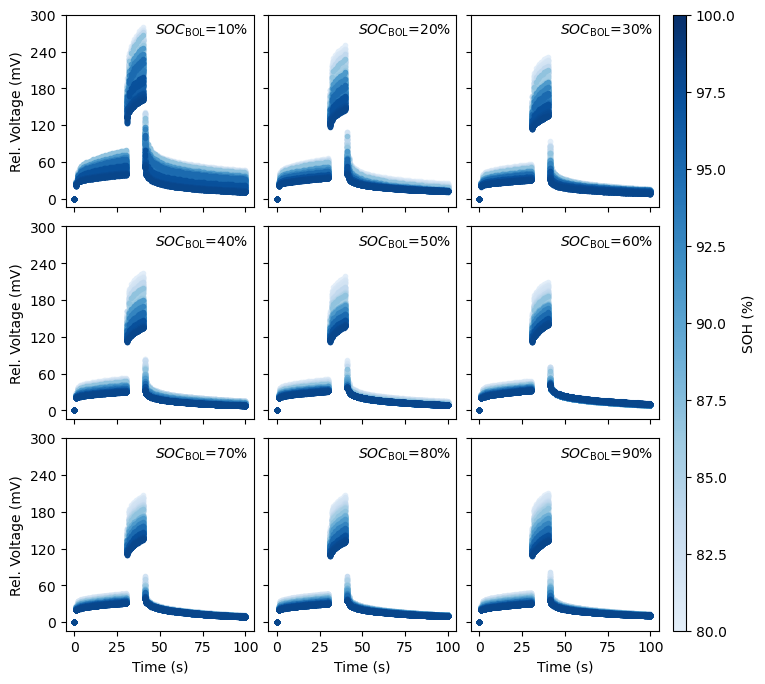

In [19]:
fig, axes, cmap, anns = plot_slowpulses(
	dataset_id='UConn-ILCC-NMC',
	pulse_type='chg',
	soc=None,
	soh_bounds=(80,100),
	cmap=truncate_colormap(mpl.cm.Blues, 0.1, 1.0)
)
plt.show()

# set if to True to save all plots 
if False:
	for dataset_id in ['UConn-ILCC-LFP', 'UConn-ILCC-NMC']:
		dir_save = dir_figures.joinpath("Dataset Overview", "Pulse Profiles", dataset_id)
		dir_save.mkdir(parents=True, exist_ok=True)

		socs_to_plot = list(dic_available_dataset_info[dataset_id]['pulse_socs_tested'].copy())
		socs_to_plot.append(None)
		for soc in socs_to_plot:
			for pulse_type in ['chg', 'dchg']:
				for file_type in ['png', 'pdf']:
					filename = f"PulseVoltage-v-SOH {pulse_type.upper()} {'AllSOCs' if soc is None else f'{soc}SOC'}.{file_type}"

					fig, axes, cmap, anns = plot_slowpulses(
						dataset_id=dataset_id,
						pulse_type=pulse_type,
						soc=soc,
						soh_bounds=(80,100),
						cmap=truncate_colormap(mpl.cm.Blues, 0.1, 1.0)
					)
					fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
					plt.close()
	

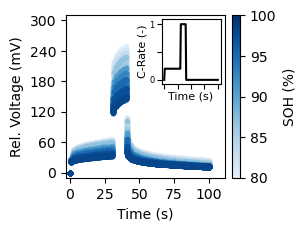

In [20]:
def _plot_pulse_w_current(dataset_id:str, soc:int, color='blue', save=False):
	assert color in ['blue', 'orange']
		
	dir_save = dir_figures.joinpath("Dataset Overview", "FT Task", dataset_id)
	dir_save.mkdir(exist_ok=True, parents=True)
	for file_type in ['png', 'pdf']:
		filename = f"PulseProfile_w_Current {soc}SOC {color.upper()}.{file_type}"

		qnom = 1.2 if dataset_id == 'UConn-ILCC-LFP' else 2.25
		fig, axes, cmap, anns = plot_slowpulses(
			dataset_id=dataset_id,
			pulse_type='chg',
			soc=soc,
			soh_bounds=(80,100),
			cmap=truncate_colormap(mpl.cm.Blues if color=='blue' else mpl.cm.Oranges, 0.1, 1.0),
			figsize=(3,2.25)
		)
		cmap.set_ticks(np.arange(80,101,5))
		axes[0].set_xlim(-3,112)
		if dataset_id == 'UConn-ILCC-NMC':
			axes[0].set_ylim([-10,310])
		else:
			axes[0].set_ylim([-5,65])
			axes[0].set_yticks(np.arange(0,61,10))
		anns[0].remove()

		ax_inset = axes[0].inset_axes([0.6,0.58,0.37,0.4])
		ax_inset.plot(get_current_profile(dataset_id=dataset_id), 'k-')
		ax_inset.tick_params(left=True, labelleft=True, bottom=True, labelbottom=False, labelsize=6, pad=1.5)
		ax_inset.set_xticks([0,25,50,75,100])
		ax_inset.set_xlabel("Time (s)", fontsize=8, labelpad=2)
		ax_inset.set_yticks([0, qnom/2, qnom], labels=[0,'',1])
		ax_inset.set_ybound(-0.15, qnom*1.1)
		ax_inset.set_ylabel("C-Rate (-)", fontsize=8, labelpad=1)
		fig.tight_layout(pad=0.5)

		if save:
			fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
			plt.close()
		else:
			if file_type == 'pdf': plt.close()
			else: plt.show()

_plot_pulse_w_current(
	dataset_id='UConn-ILCC-NMC',
	soc=20,
	color='blue',
	save=False
)

# if True save all plots
if False:
	for dataset_id in ['UConn-ILCC-NMC', 'UConn-ILCC-LFP']:
		for soc in [20,50,90]:
			for color in ['blue', 'orange']:
				_plot_pulse_w_current(
					dataset_id=dataset_id,
					soc=soc,
					color=color,
					save=True
				)


# Plot Resistance vs SOH

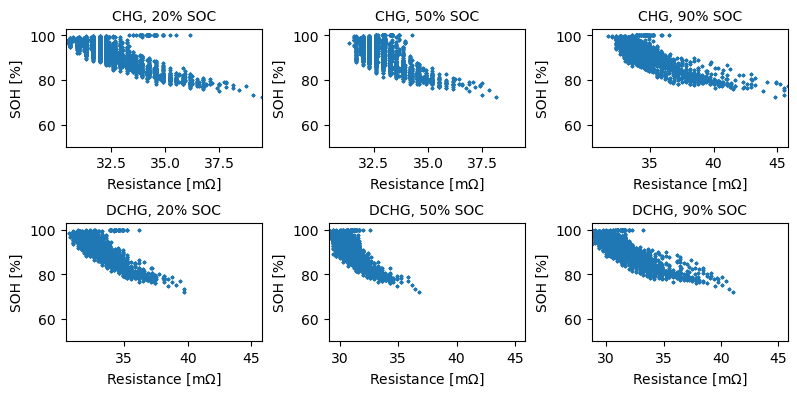

In [12]:
data = get_processed_data(dataset_id='UConn-ILCC-LFP',data_type='slowpulse',)

fig,axes = plt.subplots(figsize=(8,4), nrows=2, ncols=3)
min_r, max_r = 500, 0
for r, pulse_type in enumerate(['chg', 'dchg']):
	for c, soc in enumerate([20,50,90]):
		rs = data[f'dcir_{pulse_type}_{soc}']*1000
		max_r = np.max([np.max(rs), max_r])
		min_r = np.min([np.min(rs), min_r])
		axes[r,c].scatter(rs, data['soh'], s=2)
		axes[r,c].set_title(f"{pulse_type.upper()}, {soc}% SOC", fontsize=10)
		axes[r,c].set_xlabel("Resistance [m$\Omega$]", fontsize=10)
		axes[r,c].set_ylabel("SOH [%]", fontsize=10)
		axes[r,c].set_ylim([50,103])
		axes[r,c].set_xlim([min_r,max_r])
fig.tight_layout(pad=0.8)
plt.show()

# Plot PDF Construction from Discrete Time Steps along Pulse 

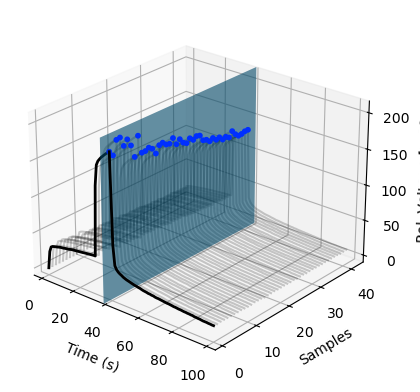

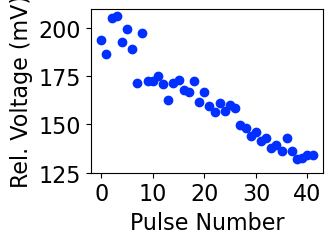

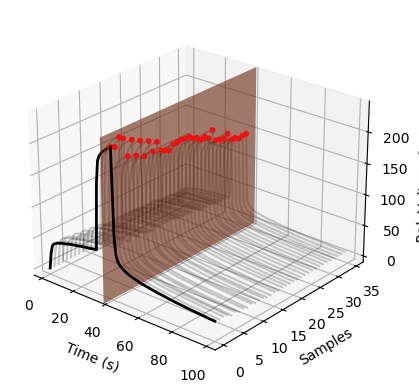

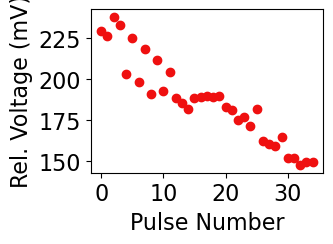

In [21]:
def plot_3d_pulse_intersection_at_time(vs, time_idx:int, color_scheme:str='blue'):
	color_schemes = {
		'blue':   ['#00aaf7', '#002fff'],		# plane color, point color
		'orange': ['#ff5e24', '#ef1010']
	}
	assert color_scheme in color_schemes.keys()
	fig = plt.figure()
	ax = plt.axes(projection='3d')
	ax.computed_zorder = False

	#region: create grid for intersecting plan
	n_grid = 2
	plane_y, plane_z = np.meshgrid(np.linspace(-2, len(vs)+2, n_grid), np.linspace(-10, np.max(vs)*1000+10, n_grid))
	plane_x = (time_idx-1) * np.ones_like(plane_y)
	#endregion

	#region: plot pulse voltage behind plane
	ax.plot3D(
			np.arange(0, len(vs[0][:time_idx]), 1),
			np.full_like(vs[0][:time_idx], 0),
			vs[0][:time_idx]*1000, 
			'-', alpha=1.0, color='black', linewidth=2, zorder=2)
	for i in range(1, len(vs)):
		ax.plot3D(
			np.arange(0, len(vs[i][:time_idx]), 1),
			np.full_like(vs[i][:time_idx], i),
			vs[i][:time_idx]*1000, 
			'-', alpha=0.2, color='black')
	#endregion
	# plot plane
	ax.plot_surface(plane_x, plane_y, plane_z, color=color_schemes[color_scheme][0], alpha=0.6, zorder=6)

	#region: plot points voltage in front of plane
	for i in range(1, len(vs)):
		ax.plot3D(
			np.arange(time_idx, time_idx + len(vs[i][time_idx:]), 1),
			np.full_like(vs[i][time_idx:], i),
			vs[i][time_idx:]*1000, 
			'-', alpha=0.2, color='black')
	#region: plot intersection points
	data_dic = {
		'x':np.full(len(vs), time_idx),
		'y':np.arange(0, len(vs)),
		'z':vs[:,time_idx]*1000,
		'plane_color':color_schemes[color_scheme][0],
		'point_color':color_schemes[color_scheme][1]
	}
	ax.scatter3D(
		data_dic['x'],
		data_dic['y'],
		data_dic['z'],
		c=color_schemes[color_scheme][1], alpha=1.0, zorder=10, s=10
	)
	#endregion
	ax.plot3D(
		np.arange(time_idx, time_idx + len(vs[0][time_idx:]), 1),
		np.full_like(vs[0][time_idx:], 0),
		vs[0][time_idx:]*1000, 
		'-', alpha=1.0, color='black', linewidth=2, zorder=10)
	#endregion

	ax.set_xlim([-5,105])
	ax.set_ylim([np.min(plane_y),np.max(plane_y)])
	ax.set_zlim([np.min(plane_z),np.max(plane_z)])

	ax.set_xlabel("Time (s)")
	ax.set_ylabel("Samples")
	ax.set_zlabel(r"Rel. Voltage [$\mathrm{m\Omega}$]")
	ax.view_init(25, -50)
	
	return fig, ax, data_dic


dataset_id = 'UConn-ILCC-NMC'
pulse_type = 'chg'
source_soc = 90
target_soc = 20
time_idx = 40

#region: Load fine-tuning results - get source/target split from first trial
from scripts.modeling.fine_tuning import str_list_to_list
from scripts.config import dir_results

ft_res = pickle.load(open(
	dir_results.joinpath("finetuning_optimization/st_split_by_cell/FixedParameters/FixedParameters_Results_0.pkl"), 
	'rb')).iloc[0]
source_cell_ids = np.hstack([
    str_list_to_list(ft_res['source_train_ids']),
    str_list_to_list(ft_res['source_test_ids']),
])
target_cell_ids = np.hstack([
    str_list_to_list(ft_res['target_train_ids']),
    str_list_to_list(ft_res['target_test_ids']),
])
#endregion

voltages_source, soh_source = get_voltage_soh_at_soc(
    dataset_id=dataset_id, 
    pulse_type=pulse_type, 
    soc=source_soc, 
    soh_bounds=(80,100),
    cell_ids=source_cell_ids)
voltages_target, soh_target = get_voltage_soh_at_soc(
    dataset_id=dataset_id, 
    pulse_type=pulse_type, 
    soc=target_soc, 
    soh_bounds=(80,100),
    cell_ids=target_cell_ids)


fig, ax, data_s = plot_3d_pulse_intersection_at_time(
	voltages_source[::4], 
	time_idx=time_idx, 
	color_scheme='blue')
plt.show()

fig, ax = plt.subplots(figsize=(3,2.125))
ax.scatter(data_s['y'], data_s['z'], c=data_s['point_color'])
ax.set_xlabel("Pulse Number", fontsize=16)
ax.set_ylabel("Rel. Voltage (mV)", fontsize=16)
ax.set_yticks([125,150,175,200])
ax.set_xticks([0,10,20,30,40])
ax.tick_params(axis='both', labelsize=16)
plt.show()

fig, ax, data_t = plot_3d_pulse_intersection_at_time(
	voltages_target[::2], 
	time_idx=time_idx, 
	color_scheme='orange')
plt.show()

fig, ax = plt.subplots(figsize=(3,2.125))
ax.scatter(data_t['y'], data_t['z'], c=data_t['point_color'])
ax.set_xlabel("Pulse Number", fontsize=16)
ax.set_ylabel("Rel. Voltage (mV)", fontsize=16)
ax.set_yticks([150,175,200,225])
ax.set_xticks([0,10,20,30])
ax.tick_params(axis='both', labelsize=16)
plt.show()


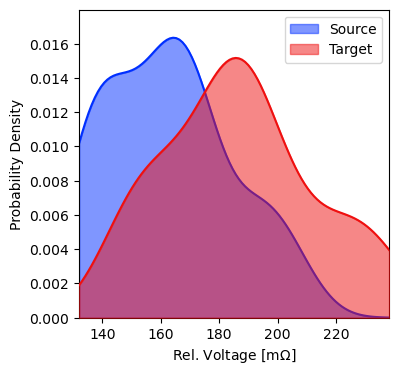

In [25]:
n_bins = 15
fig, ax = plt.subplots(figsize=(4,4))
all_zs = np.hstack([data_s['z'], data_t['z']])
z_bins = np.linspace(np.min(all_zs), np.max(all_zs), n_bins)

# s_cnts, _, _ = ax.hist(data_s['z'], bins=z_bins, density=True, color=data_s['point_color'], alpha=0.2)
# t_cnts, _, _ = ax.hist(data_t['z'], bins=z_bins, density=True, color=data_t['point_color'], alpha=0.2)

from scipy.stats import gaussian_kde
kde_s = gaussian_kde(data_s['z'])
kde_t = gaussian_kde(data_t['z'])
kde_grid = np.linspace(np.min(all_zs), np.max(all_zs), 100)

ax.plot(kde_grid, kde_s(kde_grid), '-', color=data_s['point_color'], zorder=2)
ax.fill_between(kde_grid, np.zeros_like(kde_grid), kde_s(kde_grid), 
                color=data_s['point_color'], alpha=0.5, zorder=2, label='Source')
ax.plot(kde_grid, kde_t(kde_grid), '-', color=data_t['point_color'], zorder=3)
ax.fill_between(kde_grid, np.zeros_like(kde_grid), kde_t(kde_grid), 
                color=data_t['point_color'], alpha=0.5, zorder=3, label='Target')

ax.set_xlabel("Rel. Voltage [$\mathrm{m}\Omega$]")
ax.set_ylabel("Probability Density")
ax.set_xlim(np.min(all_zs), np.max(all_zs))
ax.set_ylim(0, np.max(np.hstack([kde_s(kde_grid), kde_t(kde_grid)]))*1.1)
ax.legend()
# fig.savefig(dir_save.joinpath("pdfs source target.pdf"), dpi=300, bbox_inches='tight')
plt.show()